In [1]:
import os
import torch
from src.utilities.polar_traversal import (scale_mesh, flip_mesh)
from torchvision.transforms import (ToPILImage, GaussianBlur)
from src.augment.geoaug import GeoAugment

from src.config import get_parser

In [6]:
from src.render.mesh_face_renderer import MeshFaceRenderer
    
config = get_parser().parse_args(args=[])   

config.fast_image_size = 512
config.raster_faces_per_pixel = 4
config.lights_direction = [0.0, 0.0, 3.0]
config.specular_color = [0.15, 0.15, 0.15]
R = MeshFaceRenderer(config)
device = torch.device('cuda')

torch.Size([1, 1, 512, 512])


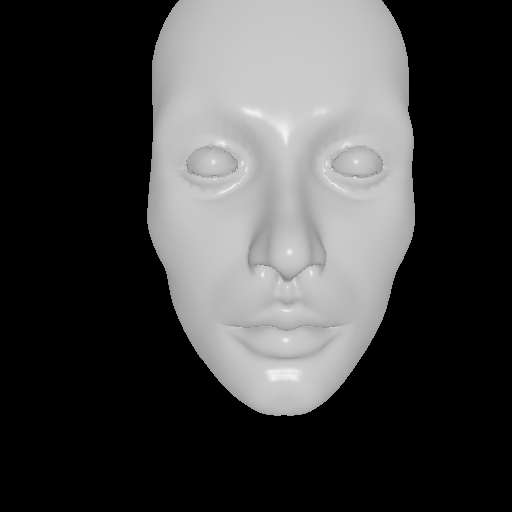

In [7]:
mesh  = flip_mesh(scale_mesh('./data/female_face.stl', offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()
faces = torch.tensor(mesh.faces, device=device)[None]

verts = GeoAugment(verts, config.geoaug_policy)[None]
renders =  R(verts, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

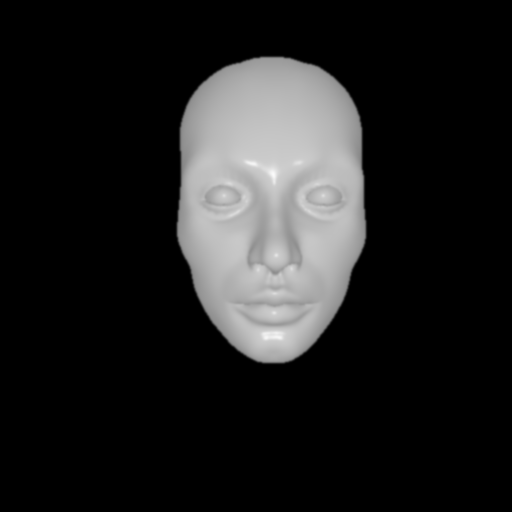

In [12]:
blurred = GaussianBlur(13, 1)(renders.expand(3, -1, -1, -1))#.shape
img = ToPILImage()(blurred[0])
img

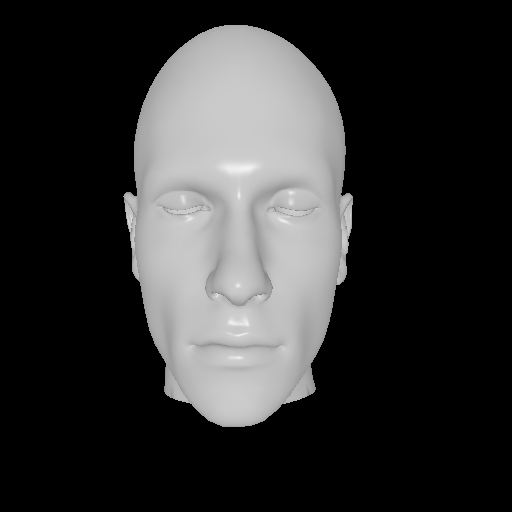

In [8]:
file = '/home/bobi/Desktop/db/data/stl_head/abe_white_inpatient.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()
faces = torch.tensor(mesh.faces, device=device)[None]

verts = GeoAugment(verts, config.geoaug_policy)[None]
renders =  R(verts, faces, device)
renders.shape
img = ToPILImage()(renders[0])
img

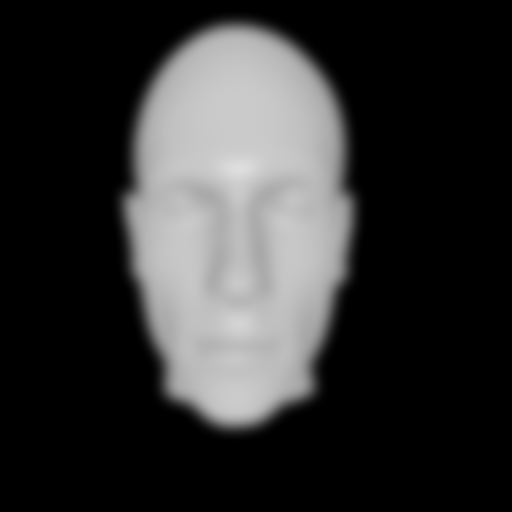

In [11]:
blurred = GaussianBlur(31, 7)(renders.expand(3, -1, -1, -1))#.shape
img = ToPILImage()(blurred[0])
img

In [16]:
img.save("./converted.png", format="png")

In [25]:
stl_dir = '/home/bobi/Desktop/db/data/stl_head/'
stls = [s for s in os.listdir(stl_dir) if s.endswith('.stl')]  
stls.sort()
stls

['abe_white_inpatient.stl',
 'abigaile_ortiz_tomb_raider.stl',
 'ada_wong_resident_evil.stl',
 'administrator_evil_within.stl',
 'aidan_overkill_walking_dead.stl',
 'aloy_horizon_zero_dawn.stl',
 'amelia_croft_tomb_raider.stl',
 'anakin_battlefront_2.stl',
 'angela_civilian_detroit.stl',
 'annie_dead_rising.stl',
 'aphrodite_ascendant_one.stl',
 'ares_ascendant_one.stl',
 'artemis_ascendant_one.stl',
 'ashley_until_dawn_3ds.stl',
 'badgirl_no_more_heroes.stl',
 'badman_no_more_heroes.stl',
 'becky_hidden_agenda.stl',
 'black_lightning_injustice_2.stl',
 'bridger_overkill_walking_dead.stl',
 'cameron_burke_far_cry.stl',
 'carl_detroit.stl',
 'cassie_drake_uncharted.stl',
 'catherine_hidden_agenda.stl',
 'chloe_detroit.stl',
 'claire_resident_evil.stl',
 'connor_detroit.stl',
 'daniel_detroit.stl',
 'dante_dmc.stl',
 'dengar_battlefront_2.stl',
 'dooku_battlefront_2.stl',
 'earl_whitehorse_far_cry.stl',
 'eden_girl_detroit.stl',
 'elena_fisher_uncharted.stl',
 'elisa_two_souls.stl',
 'el

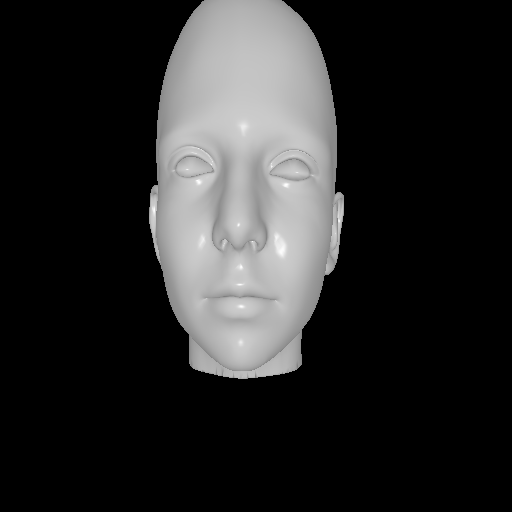

In [35]:
rndr_root = './data/renders/'
for i, stl_file in enumerate(stls):
    mesh  = flip_mesh(scale_mesh(os.path.join(stl_dir, stl_file), offset=-0.20))
    orig_verts = torch.tensor(mesh.vertices, device=device).float()
    faces = torch.tensor(mesh.faces, device=device)[None]
    stl_name = stl_file.replace('.stl', '')
    rndr_dir = os.path.join(rndr_root, stl_name)
    if not os.path.exists(rndr_dir):
        os.makedirs(rndr_dir)
    for i in range(100):        
        verts = GeoAugment(orig_verts.clone(), config.geoaug_policy)[None]
        renders =  R(verts, faces, device)
        renders.shape
        img = ToPILImage()(renders[0])
        img.save(os.path.join(rndr_dir, stl_name+ '_' + f"{i}.png".zfill(7)), format="png")
    
img    

In [6]:
from src.data.render_dataset import RenderDataset

config = get_parser().parse_args(args=[])
ds = RenderDataset(config)
ds

In [10]:
ds[0]['image'].shape

torch.Size([3, 128, 128])

In [8]:
from src.data.fast_datamodule import FastDataModule

dm = FastDataModule(config, RenderDataset)
dm

In [9]:
next(iter(dm.train_dataloader()))

{'image': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
